# Análise de Cluster para Modelo de Clustering
O objetivo da análise consiste em criar um modelo de clusterização para entendimento dos padrões de dados dos grupos potenciais criados pelo algortimo, a fim de construir ações para melhoria dos processos de exportação. Os dados usados para construção do modelo foram obtidos através dos dataset gerado na tarefa de eda_preprocessing. 
Esse modelo será instanciado via api para consumo pelo usuário ou acessado através de uma interface gráfica disponível e construída com o framework Streamlit.

**Resumo dos Procedimentos Realizados:**<br>
* Set up do conjunto de bibliotecas da linguagem Python e carregamento dos dados.<br>
  Tratamento dos dados: scale dos dados usando PowerTransformer.<br>


**Análises**:
 * Técnica Elbow Score para avaliar número de clusters potenciais.<br>
  Avaliação complementar com Silhouette Score.<br>
  Comparativo do Silhouette Score com Davies_Bouldin e Calinski_Harabasz.<br>
  Redução de Dimensionalidade com PCA.<br>
  Análise das Características dos clusters.<br>



## Set up
Carregamento de bibliotecas, funções e objetos para execução dos processos de construção de ajuste de modelo.

In [1]:
# carregamento de bibliotecas

# manipulação de dados
import sys
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# visualização e modelos de clusterização
sys.path.append('..')
from src.train import analise_silhouette, visualizar_coluna_por_cluster
from src.eda_preprocessing import vif_analise
from yellowbrick.cluster import kelbow_visualizer, silhouette_visualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# interatividade
from ipywidgets import interact



## Carregamento dos dados

In [2]:
tbl_export_clustering = pd.read_csv('../data/processed/dataset_exportacao_clustering_processed.csv')
tbl_export_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   pais                              179 non-null    object 
 1   media_PIB_total_(dolar_corrente)  179 non-null    float64
 2   media_população_total             179 non-null    float64
 3   media_PIB_per_capita              179 non-null    float64
 4   media_taxa_crescimento_PIB        179 non-null    float64
 5   media_taxa_inflação_(CPI)         179 non-null    float64
 6   media_expectativa_vida            179 non-null    float64
 7   media_taxa_alfabetização          179 non-null    float64
 8   media_exportacao_abs              179 non-null    float64
 9   media_importacao_abs              179 non-null    float64
 10  media_IDH_estimado                179 non-null    float64
 11  soma_qtde_kg                      179 non-null    int64  
 12  soma_val

# Tratamento dos Dados

In [3]:
# aplicação de processo scale para nivelamento dos dados para o dataset de clustering.

tbl_export_clustering_num = tbl_export_clustering.drop(columns='pais')

# scale dos dados
transformer = PowerTransformer(method='yeo-johnson', standardize=True)
output = transformer.fit_transform(tbl_export_clustering_num)

# construção de um dataset transformado
tbl_export_clustering_num = pd.DataFrame(
    output,
    columns=tbl_export_clustering_num.columns,
    index=tbl_export_clustering_num.index
)

# juncao dos datasets
tbl_export_clustering_cat = tbl_export_clustering.select_dtypes(include='object')

tbl_export_clustering = tbl_export_clustering_cat.join(tbl_export_clustering_num)




## Avaliação de Modelo

In [4]:
# separação dos dados
X = tbl_export_clustering.drop(columns='pais', axis=1)

# Elbow Score para avaliar número de cluster potenciais
A técnica de elbow score nos ajuda a avaliar a quantidade de clusters ideal de cluster a partir de um conjunto de dados.<br> Para essa análise, consideramos um modelo Kmeans ().<br> O visual avalia o ponto de clusters(k) ótimo que entrega a maior redução de score (dispersão intra-cluster: variação de distância dos pontos dentro do mesmo cluster).<br>
Para o cenário, encontramos o maior redução potencial no ponto 5, pois atingiu a menor quantidade de cluster necessária para uma redução significativa comparada a pontos menores.

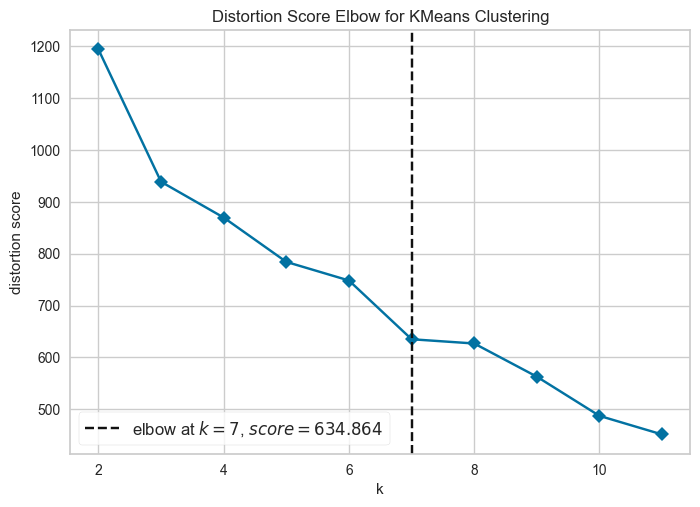

In [5]:
# teste elbow score:
kelbow_visualizer(KMeans(), X, k=11, timings=False)
plt.show()

# Analisando Clusters Potenciais com Silhouette Score
O gráfico silhouette permite verificar a coesão entre os pontos pertencentes ao cluster e a distância do cluster mais próximo. A medida de decisão, está definida no eixo X, como um valor entre -1 (no cluster errado), 0(ponto de fronteira) e 1 (bem alocado ao cluster).<br>
No cenário definido como ótimo através do Elbow Score, percecemos uma pequena variação negativa entre dois clusters, indicando a presença de pontos mal alocados, enquanto dois estão acima da média geral, indicando um nível de agrupamento ótimo e os demais abaixo da média, indicando um agrupamento razoável ou uma clusterização mal realizada.<br>
Assim, uma possibilidade de decisão pode levar a redução da quantidade de clusters para agrupar melhor os pontos. 

In [6]:
# silhouette_visualizer iterativo
@interact(n_cluster=(2, 11))
def interativo(n_cluster):
    analise_silhouette(df=X, n_cluster=n_cluster)


interactive(children=(IntSlider(value=6, description='n_cluster', max=11, min=2), Output()), _dom_classes=('wi…

# Comparativo com Davies_Bouldin e Calinski_Harabasz
Além da coesão dos clusters, podemos analisar o grau de similaridade entre os clusters, identificando clusters mais distintos e compactos com Davies_Bouldin score (menor valor, menor similaridade) e a dispersão dentro e fora do cluster (maior valor,maior a separação).<br>
Assim, através desses indicadores, percebemos uma melhor acomodação dos clusters entre 2 a 4 clusters.

In [7]:
# dataframe com as medidas de inercia, silhouette, davies_bouldin e calinski_harabasz.

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,1193.912672,0.505319,0.774704,194.519635
3,939.734430,0.335049,1.246834,146.670555
4,844.150255,0.306770,1.535649,114.838839
5,780.442180,0.304647,1.509521,96.178509
6,673.379635,0.283966,1.381289,94.164809
7,627.406358,0.281921,1.223794,85.834351
8,596.194977,0.260886,1.376917,78.252602
9,544.133558,0.267135,1.245815,76.616598
10,517.922379,0.285723,1.197265,72.079681


# Redução de Dimensionalidade com PCA
Como verificamos no processo de eda, existe uma alta colinearidade entre as features, o que pode impactar no processo de modelagem. Uma alternativa de tratamento é aplicar a clusterização a partir de um processo de redução de componentes.<br>
Conforme as análises abaixo,identificamos que 2 componentes conseguem responder 75% da variância dos dados, logo isso facilita uma análise bi-dimensional pelo usuário.<br>
Assim, aplicando a relação das features com os componentes, percebemos que as features socioeconômicas tem mais influência no componente 1 (através dos valores positivos), enquanto que as features de transação tem maior influência no componente 2.

In [8]:
# análise de multicolinearidade dos dados
vif_analise(tbl_export_clustering.drop(columns='pais'))

,Feature,VIF
0,media_PIB_total_(dolar_corrente),468.264645
1,media_população_total,280.556726
2,media_PIB_per_capita,130.444244
3,media_taxa_crescimento_PIB,1.218265
4,media_taxa_inflação_(CPI),1.823806
5,media_expectativa_vida,103.516047
6,media_taxa_alfabetização,50.951003
7,media_exportacao_abs,1029.765674
8,media_importacao_abs,1015.232575
9,media_IDH_estimado,2.327499


In [9]:
# Coeficientes de relação entre cada variável e cada componente
pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(pca.components_))],
                        index=X.columns)

print("Tabela de Relação entre Colunas e Componentes Principais:")
loadings

Tabela de Relação entre Colunas e Componentes Principais:


,PC1,PC2
media_PIB_total_(dolar_corrente),0.330314,-0.111971
media_população_total,0.313924,-0.129435
media_PIB_per_capita,0.305212,-0.127526
media_taxa_crescimento_PIB,0.123753,-0.067380
media_taxa_inflação_(CPI),0.181657,-0.004561
media_expectativa_vida,0.317945,-0.207268
media_taxa_alfabetização,0.316186,-0.202163
media_exportacao_abs,0.315406,-0.101763
media_importacao_abs,0.314907,-0.106114
media_IDH_estimado,0.203582,-0.291274


In [10]:
# explicação da variância a partir dos componentes principais

pd.DataFrame(
    {'explained_var': pca.explained_variance_ratio_, 'explained_var_cumsum': pca.explained_variance_ratio_.cumsum()},
    index=loadings.columns
)

,explained_var,explained_var_cumsum
PC1,0.606087,0.606087
PC2,0.153523,0.759610


In [11]:
# atribuindo os clusters ao modelo
model = KMeans(3, random_state=0).fit(X)
centroids = model.cluster_centers_
labels = model.labels_
inertia = model.inertia_
X = X.assign(cluster=labels)

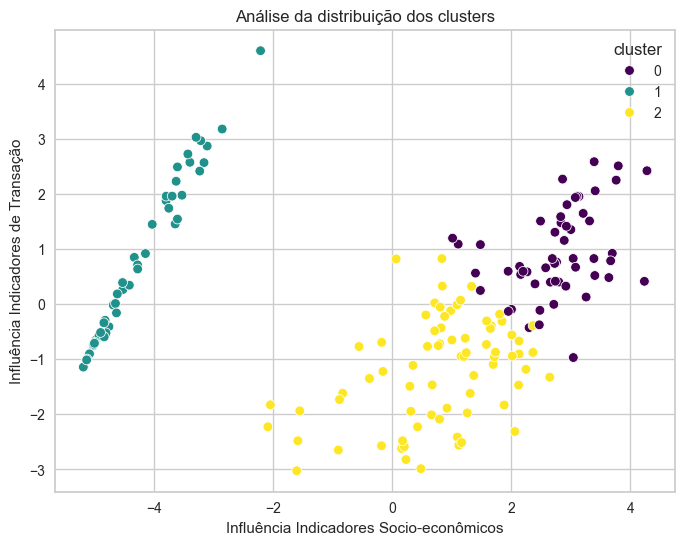

In [12]:
# análise dos cluster a partir dos componentes principais
plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=X['cluster'], palette='viridis')
plt.title('Análise da distribuição dos clusters')
plt.xlabel('Influência Indicadores Socio-econômicos')
plt.ylabel('Influência Indicadores de Transação')
plt.show()

## Análise das Características dos Clusters
Comparativo de performance de cada cluster criado em cada variável da tabela partir da visualização dos dados por gráfico de barras um gráfico de distribuição adicionando a média como referência. <br> 
O objetivo consiste em identificar padrões de cada cluster e definir quais são as features mais importantes para atribuir um ponto de dados a um cluster.

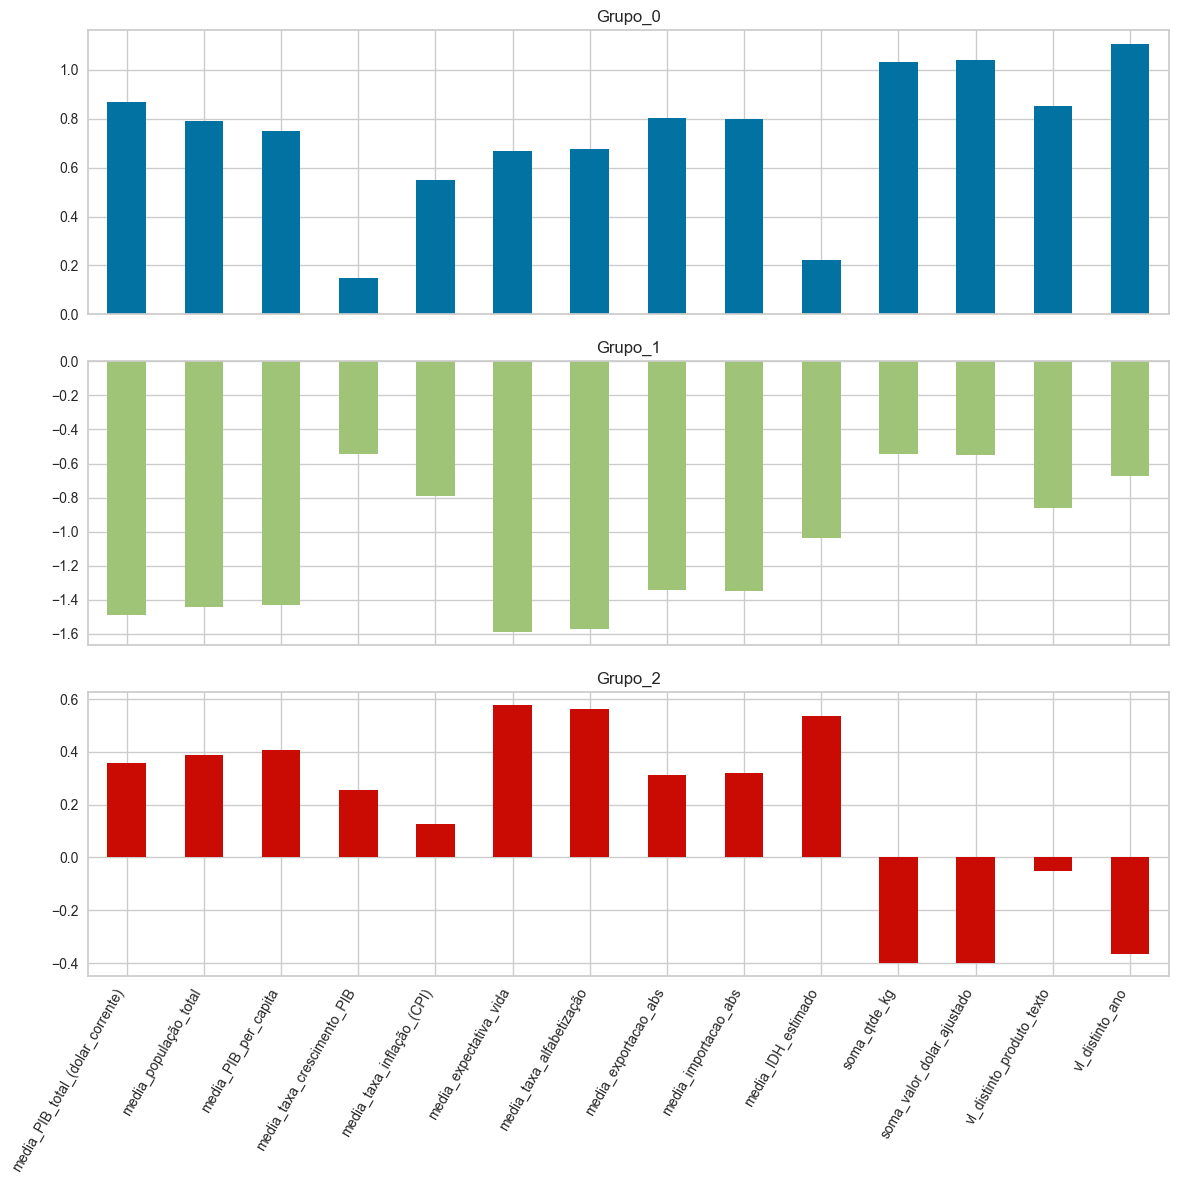

In [13]:
# análise de desempenho dos clusters em cada feature
(pd.DataFrame(centroids, columns=X.drop(columns='cluster').columns)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True, figsize=(12,12), legend=False)
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

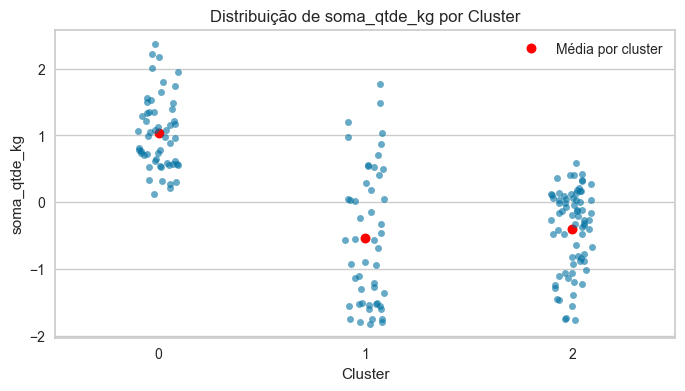

In [14]:
# análise da distribuição dos cluster por cada coluna do dataset
visualizar_coluna_por_cluster(tbl=X,coluna='soma_qtde_kg')

# Considerações sobre o Modelo
O modelo será instanciado via api, apesar do alto custo, uma vez que o objetivo é dar ao usuário a possibilidade de definir clusters e identificar padrões.<br>
Verificamos que o modelo aprende muito bem com os dados e consegue definir volume de clusters significativos para pequenas quantidades.<br>
Aplicando Redução de Dimensionalidade, temos dois componentes explicando variáveis semelhantes, permitindo que o usuário consiga entender a influência de cada grupo de features do no processo de clusterização: PC1 tem boa explicabilidade para variáveis socioeconômicas, enquanto PC2 tem para variáveis de transação, e ambas explicam aproximadamente 80% da variabilidade do modelo.<br>